In [1]:
import pandas as pd
import ast
import gzip
import seaborn as sns
import nltk
from dateutil.parser import parse
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

### Steam Games

In [3]:
# Cargo el archivo en un DataFrame y veo su información.
# Por cuestiones del tamaño del archivo prefiero cargar la información directamente desde el archivo comprimido.
steam_games = pd.read_json(f'../Datasets/steam_games.json.gz',compression='gzip',lines=True)
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 11.9+ MB


In [4]:
# Elimino las filas que son enteramente nulas.
steam_games.dropna(how='all',inplace=True)
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 3.4+ MB


In [5]:
# Busco si en la columna "id" hay valores nulos
steam_games[steam_games['id'].isnull()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88384,None,None,None,None,http://store.steampowered.com/,None,None,None,None,19.99,0.0,NaN,None
119271,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",None,"[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [6]:
# Una de las filas encontradas solo tiene un url que te lleva a la pagina principal de steam.
# La otra fila es un duplicado de otra. Por lo que también se eliminará.
steam_games[steam_games['title'] == 'Batman: Arkham City - Game of the Year Edition'] 

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
89378,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260/Batma...,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",http://steamcommunity.com/app/200260/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,200260.0,"Rocksteady Studios,Feral Interactive (Mac)"
119271,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",None,"[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [7]:
steam_games.dropna(subset=['id'],inplace=True) 

In [8]:
# Busco los duplicados en id
duplicados = steam_games['id'].value_counts() > 1
steam_games[steam_games['id'].isin(duplicados[duplicados].index)]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
102204,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,0.0,612880.0,Machine Games
102883,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,0.0,612880.0,Machine Games


In [9]:
# Se ecnontraron dos filas duplicadas, eliminaré una.
steam_games.drop_duplicates(subset='id',inplace=True,keep='first')

In [10]:
# Convierto el id a tipo entero
steam_games['id'] = steam_games['id'].astype('int') 

In [11]:
 # Cuento la cantidad de nulos
steam_games.isnull().sum()

publisher       8051
genres          3282
app_name           1
title           2049
url                0
release_date    2066
tags             162
reviews_url        0
specs            669
price           1377
early_access       0
id                 0
developer       3298
dtype: int64

In [12]:
steam_games[steam_games['app_name'].isnull()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
90890,None,"[Action, Indie]",None,None,http://store.steampowered.com/app/317160/_/,2014-08-26,"[Action, Indie]",http://steamcommunity.com/app/317160/reviews/?...,"[Single-player, Game demo]",None,0.0,317160,None


In [13]:
# El unico juego que no tiene ni titulo ni app_name tampoco tiene desarrollador o publicador, por esto se eliminara esta fila.
steam_games.dropna(subset='app_name',inplace=True)

In [14]:
# Se remplazara los nulos de developer por los de publisher.
steam_games['developer'].fillna(steam_games['publisher'],inplace=True)

In [15]:
# Se eliminaran las columnas que no seran usadas para el estudio.
steam_proc = steam_games.drop(columns=['publisher','title','url','reviews_url','early_access','specs'])

In [16]:
# Veo que tags y genres son columnas con datos similares, buscaré los nulos en esas columnas
steam_proc[steam_proc['genres'].isna()]

,genres,app_name,release_date,tags,price,id,developer
88314,None,Log Challenge,None,"[Action, Indie, Casual, Sports]",2.99,773570,None
88321,None,Icarus Six Sixty Six,None,[Casual],Free,724910,None
88329,None,After Life VR,None,"[Early Access, Indie, VR]",4.99,772590,None
88330,None,Kitty Hawk,None,"[Early Access, Action, Adventure, Indie, Casual]",2.99,640250,None
88332,None,Mortars VR,None,"[Early Access, Strategy, Action, Indie, Casual...",0.99,711440,None
...,...,...,...,...,...,...,...
120428,None,Robotpencil Presents: Exercise: Brushwork,2018-01-03,"[Design & Illustration, Tutorial]",3.99,775640,None
120429,None,Robotpencil Presents: Creative Composition,2018-01-03,"[Design & Illustration, Tutorial]",3.99,777930,None
120430,None,The Gamble House,2016-11-19,[Movie],4.99,775370,None
120431,None,Kalen Chock Presents: 2017 Free Tutorial,2018-01-03,"[Design & Illustration, Tutorial]",Free,777950,None


In [17]:
steam_proc[steam_proc['tags'].isna()]['genres']

88589             [Adventure]
88608     [Action, Adventure]
88619                [Casual]
88620                [Casual]
88668                    None
                 ...         
119935               [Casual]
119937           [Simulation]
119949                   None
119962                [Indie]
120118               [Casual]
Name: genres, Length: 162, dtype: object

In [18]:
# Voy a remplazar los nulos de genres con los valores de tags y voy a eliminar la columna tags que ya no aporta informacion.

# Creo un conjunto de géneros únicos en base a la columna 'genres'.
genres = set(item for val in steam_proc['genres'].dropna() for item in val)

# Filtro las etiquetas 'tags' para mantener solo aquellas que están presentes en 'genres'
steam_proc['tags'] = steam_proc['tags'].apply(lambda x: [item for item in x if item in genres] if isinstance(x, list) else x) 

# Relleno los valores nulos en la columna 'genres' con valores de 'tags'
steam_proc['genres'].fillna(steam_proc['tags'], inplace=True)

def agregar_genres_tags(fila):
    genres = fila['genres']
    tags = fila['tags']
    if isinstance(tags,list) and isinstance(genres,list):
        for tag in tags:
            if tag not in genres:
                genres.append(tag)
    return genres

# Aplico la función 'agregar_genres_tags' al dataframe
steam_proc['genres'] = steam_proc.apply(lambda fila: agregar_genres_tags(fila), axis=1)

# Descarto la columna 'tags'
steam_proc.drop(columns=['tags'], inplace=True)

In [19]:
# Genero dummies para genres 
steam_proc['genres'] =  steam_proc['genres'].apply(lambda x:".".join(x) if isinstance(x, list) else x)
dummies = steam_proc['genres'].str.get_dummies(sep='.')
#dummies = dummies.groupby(dummies.columns, axis=1).sum()
steam_proc = pd.concat([steam_proc,dummies],axis=1)


In [20]:
steam_proc.head()

,genres,app_name,release_date,price,id,developer,Accounting,Action,Adventure,Animation &amp; Modeling,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
88310,Action.Casual.Indie.Simulation.Strategy,Lost Summoner Kitty,2018-01-04,4.99,761140,Kotoshiro,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
88311,Free to Play.Indie.RPG.Strategy,Ironbound,2018-01-04,Free To Play,643980,Secret Level SRL,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
88312,Casual.Free to Play.Indie.Simulation.Sports,Real Pool 3D - Poolians,2017-07-24,Free to Play,670290,Poolians.com,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
88313,Action.Adventure.Casual,弹炸人2222,2017-12-07,0.99,767400,彼岸领域,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
88314,Action.Indie.Casual.Sports,Log Challenge,None,2.99,773570,None,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [21]:
# Paso a la columna
# Primero voy a poner en valor 0 los que tengan un str con Free
steam_proc.loc[steam_proc['price'].str.contains("Free", na=False), 'price'] = 0.0

In [22]:
# A los dos valores que incluye el precio como parte de un string lo remplazo con su valor de precio
steam_proc['price'].replace('Starting at $499.00',499.0,inplace=True)
steam_proc['price'].replace('Starting at $449.00',499.0,inplace=True)

In [23]:
# Cuando precio posee un string y Free to Play vale 1 remplazo por 0
steam_proc.loc[(steam_proc['Free to Play'] == 1) & steam_proc['price'].apply(lambda x: isinstance(x, str)), ['price']] = 0.0

In [24]:
# Veo los valores nulos de price donde Free to Play vale 1
steam_proc[pd.isna(steam_proc['price'])][['Free to Play']].value_counts()

Free to Play
0               1171
1                205
Name: count, dtype: int64

In [25]:
# A esos valores los remplazo por 1
steam_proc.loc[(steam_proc['Free to Play'] == 1) & (pd.isna(steam_proc['price'])), 'price'] = 0.0

In [26]:
# Veo la cantidad de nulos que quedaron en price respecto al total, veo que no llega al 4% de nulos
steam_proc[steam_proc['price'].isnull()].shape[0]/steam_proc.shape[0]

0.03644455510254894

In [27]:
# Elimino los valores de precio donde sean nulos o donde o donde no sean de tipo string ya que no puedo hacer más analisis.
steam_proc = steam_proc[steam_proc['price'].apply(lambda x: isinstance(x, float))]
steam_proc.dropna(subset='price',inplace=True)

In [28]:
# Convierto la columna en formato float.
steam_proc['price'] = steam_proc['price'].astype('float')

In [29]:
print(f'Porcentaje de nulos : {1 - steam_proc.dropna(subset=["developer","release_date"]).shape[0] / steam_proc.shape[0]}')

Porcentaje de nulos : 0.10079472766039932


In [30]:
# Quedaron valores nulos en release_date, developer y specs que equivalen aproximadamente al 11% del dataframe. 
# Y al no poder hacer otro tratado se eliminaran
steam_proc.dropna(subset=['developer','release_date'],inplace=True)
steam_proc.isnull().sum()

genres                       98
app_name                      0
release_date                  0
price                         0
id                            0
developer                     0
Accounting                    0
Action                        0
Adventure                     0
Animation &amp; Modeling      0
Audio Production              0
Casual                        0
Design &amp; Illustration     0
Early Access                  0
Education                     0
Free to Play                  0
Indie                         0
Massively Multiplayer         0
Photo Editing                 0
RPG                           0
Racing                        0
Simulation                    0
Software Training             0
Sports                        0
Strategy                      0
Utilities                     0
Video Production              0
Web Publishing                0
dtype: int64

In [31]:
# Convierto la columna release_date en datetime y genero la columna año
steam_proc['release_date'].value_counts()

release_date
2012-10-16    100
2017-08-31     90
2017-09-26     88
2017-07-25     78
2017-12-19     74
             ... 
2000-01-31      1
1994-08-15      1
1987-10-05      1
2021-12-31      1
2004-03-01      1
Name: count, Length: 3293, dtype: int64

In [32]:
# Verifico el formato de los año

# Función para verificar el formato 'YYYY-MM-DD'
def is_valid_date_format(date_str):
    regex = r'^\d{4}-\d{2}-\d{2}$'
    return re.match(regex, date_str) is not None

# Crear una máscara booleana para las fechas que no tienen el formato 'YYYY-MM-DD'
invalid_date_mask = ~steam_proc['release_date'].astype(str).apply(is_valid_date_format)

# Filtrar las filas con fechas que no tienen el formato 'YYYY-MM-DD'
invalid_dates = steam_proc[invalid_date_mask]

# Mostrar las filas con fechas que no tienen el formato 'YYYY-MM-DD'
print(steam_proc[invalid_date_mask]['release_date'])

88354                        Beta测试已开启
88560                         Jun 2009
88816                         Oct 2010
88819                         Oct 2010
88820                         Oct 2010
88909                         Feb 2011
90917                         Sep 2014
91812                         Apr 2015
91814                         Apr 2015
94022                             2017
94314                         Apr 2016
94954                         Jul 2016
95444                      Coming Soon
98585                             soon
98873                         Jul 2017
99075                      Summer 2017
101168                            2018
101344                            SOON
101905                     Coming soon
101992               Demo coming soon.
102638                    January 2019
103983                            2018
104571                Release Date TBA
104701                            2017
104953                        Jul 2017
105517     Early Access S

In [33]:
# Hago una funcion para tratar los valores que no tienen el formato YYYY-MM-DD

def arreglar_errores(fecha: str):
    try:
        # Intenta convertir la fecha directamente a entero
        return int(fecha)
    except ValueError:
        try:
            # Intenta dividir la fecha usando un espacio en blanco como delimitador y convierte la segunda parte a entero
            return int(fecha.split(" ")[1])
        except (IndexError, ValueError):
            try:
                # Intenta dividir la fecha usando "." como delimitador y convierte la tercera parte a entero
                return int(fecha.split(".")[2])
            except (IndexError, ValueError):
                try:
                    # Intenta dividir la fecha usando un espacio en blanco como delimitador y convierte la quinta parte a entero
                    return int(fecha.split(" ")[4])
                except (IndexError, ValueError):
                    # Si no se puede convertir, devuelve None
                    return None

In [34]:
steam_proc.loc[invalid_date_mask, 'Year'] = steam_proc.loc[invalid_date_mask, 'release_date'].apply(arreglar_errores)

# Convertir las fechas válidas a datetime y extraer el año
valid_date_mask = ~invalid_date_mask
steam_proc.loc[valid_date_mask, 'Year'] = pd.to_datetime(steam_proc.loc[valid_date_mask, 'release_date'], errors='coerce').dt.year

In [35]:
steam_proc['Year'] = steam_proc['Year'].astype(float)

In [36]:
print(steam_proc.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27834 entries, 88310 to 120443
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   genres                     27736 non-null  object 
 1   app_name                   27834 non-null  object 
 2   release_date               27834 non-null  object 
 3   price                      27834 non-null  float64
 4   id                         27834 non-null  int32  
 5   developer                  27834 non-null  object 
 6   Accounting                 27834 non-null  int64  
 7   Action                     27834 non-null  int64  
 8   Adventure                  27834 non-null  int64  
 9   Animation &amp; Modeling   27834 non-null  int64  
 10  Audio Production           27834 non-null  int64  
 11  Casual                     27834 non-null  int64  
 12  Design &amp; Illustration  27834 non-null  int64  
 13  Early Access               27834 non-null  int

In [37]:
# A 'release_date' la eliminare ya que no la voy a utilizar.
steam_proc.drop(columns=['release_date'],inplace=True)

In [38]:
steam_proc['Year'].isnull().sum()
steam_proc['Year'].dropna(inplace=True)

In [39]:
# Por ultimo exporto como csv el proceso de ETL
steam_proc.to_csv(f'../datasets/steam_games.csv',index=False)

## User Reviews

In [40]:
user_reviews_gz = "../datasets/user_reviews.json.gz"
filas=[]
with gzip.open(user_reviews_gz, 'rt', encoding='MacRoman') as archivo:
    for line in archivo.readlines():
        filas.append(ast.literal_eval(line))

user_review = pd.DataFrame(filas)

In [41]:
user_review

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."
...,...,...,...
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,"[{'funny': '', 'posted': 'Posted May 31.', 'la..."
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,"[{'funny': '', 'posted': 'Posted June 17.', 'l..."
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,"[{'funny': '1 person found this review funny',..."
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"[{'funny': '', 'posted': 'Posted July 21.', 'l..."


In [42]:
# Veo que la columna reviews es una lista de diccionarios, donde cada item de la lista equivale a un producto distinto que ese usuario haya comendado, y cada cada diccionario guarda variables referentes al item y su posteo.
# Primero voy a usar explode para duplicar las filas por cada item de la lista, y luego voy a generar un dataframe con el diccionario nuevo y lo concatenare a traves de las columnas con el el dataframe con filas duplicadas

user_review_explode = user_review.explode('reviews') 
user_review_explode = pd.concat([user_review_explode.drop(['reviews'],axis=1),user_review_explode['reviews'].apply(pd.Series)],axis=1)  

In [43]:
# Elimino columnas que no seran usadas para el estudio
user_review_explode.drop(columns=['user_url','funny','helpful','last_edited',0],inplace=True)

In [44]:
user_review_explode

,user_id,posted,item_id,recommend,review
0,76561197970982479,"Posted November 5, 2011.",1250,True,Simple yet with great replayability. In my opi...
0,76561197970982479,"Posted July 15, 2011.",22200,True,It's unique and worth a playthrough.
0,76561197970982479,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
1,js41637,"Posted June 24, 2014.",251610,True,I know what you think when you see this title ...
1,js41637,"Posted September 8, 2013.",227300,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...
25797,76561198312638244,Posted July 10.,70,True,a must have classic from steam definitely wort...
25797,76561198312638244,Posted July 8.,362890,True,this game is a perfect remake of the original ...
25798,LydiaMorley,Posted July 3.,273110,True,had so much fun plaing this and collecting res...
25798,LydiaMorley,Posted July 20.,730,True,:D


In [45]:
# Ahora a partir de la columna reveiw se hara un analisis de sentimiento, generando una nueva columna.
# Este se llamara "sentiment_analysis". Tendra 2 para sentimiento positivo, 0 para negativo y 1 para neutral
# Habiendo hecho esto elimino la columna review

#Hago el analisis de sentimiento en la columna review
nltk.download('vader_lexicon')
model_sentimiento = SentimentIntensityAnalyzer()


def analizador(review):
    # Obtener el puntaje de sentimiento usando SentimentIntensityAnalyzer
    sentimiento_score = model_sentimiento.polarity_scores(review)
    
    # Clasifico el sentimiento
    
    if review and not pd.isnull(review):
        if sentimiento_score['compound'] >= 0.5:
            return 2  # Sentimiento positivo
        elif sentimiento_score['compound'] <= -0.5:
            return 0  # Sentimiento negativo
        else:
            return 1  # Sentimiento neutral
    else:
        return 1

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\daant\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:
# Para aplicar la funcion los nulos tienen que ser vacio
user_review_explode['review'].fillna('',inplace=True)

In [47]:
user_review_explode['sentiment_analysis']  = user_review_explode['review'].apply(analizador)
user_review_explode.drop(columns='review',inplace=True) # Aplica la funcion que determina el sentimiento

<Axes: xlabel='sentiment_analysis', ylabel='Count'>

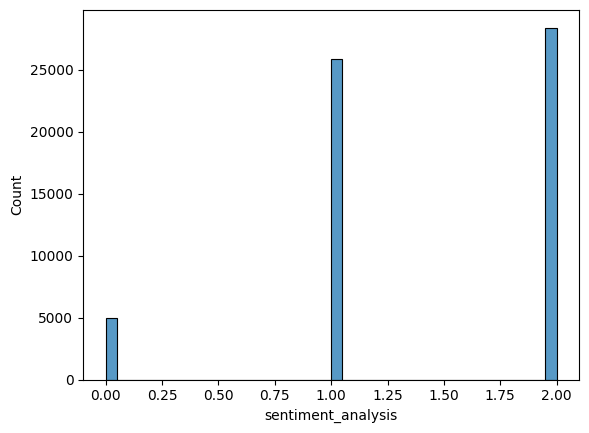

In [48]:
# Grafico el analisis por sentimiento de las reviews
sns.histplot(data=user_review_explode,x='sentiment_analysis')

In [49]:
# Busco los nulos que quedaron
user_review_explode.isnull().sum()

user_id                0
posted                28
item_id               28
recommend             28
sentiment_analysis     0
dtype: int64

In [50]:
user_review_explode[user_review_explode.isnull().any(axis=1)]

,user_id,posted,item_id,recommend,sentiment_analysis
62,gdxsd,NaN,NaN,NaN,1
83,76561198094224872,NaN,NaN,NaN,1
1047,76561198021575394,NaN,NaN,NaN,1
3954,cmuir37,NaN,NaN,NaN,1
5394,Jaysteeny,NaN,NaN,NaN,1
6135,ML8989,NaN,NaN,NaN,1
7583,76561198079215291,NaN,NaN,NaN,1
7952,76561198079342142,NaN,NaN,NaN,1
9894,76561198061996985,NaN,NaN,NaN,1
10381,76561198108286351,NaN,NaN,NaN,1


In [51]:
# Hay nulos pero coiciden con todas las columnas de reviews, por esto se eliminaran.
user_review_explode.dropna(inplace=True)

In [52]:
user_review_explode

,user_id,posted,item_id,recommend,sentiment_analysis
0,76561197970982479,"Posted November 5, 2011.",1250,True,2
0,76561197970982479,"Posted July 15, 2011.",22200,True,1
0,76561197970982479,"Posted April 21, 2011.",43110,True,2
1,js41637,"Posted June 24, 2014.",251610,True,2
1,js41637,"Posted September 8, 2013.",227300,True,2
...,...,...,...,...,...
25797,76561198312638244,Posted July 10.,70,True,2
25797,76561198312638244,Posted July 8.,362890,True,2
25798,LydiaMorley,Posted July 3.,273110,True,2
25798,LydiaMorley,Posted July 20.,730,True,2


In [53]:
# La librería dateutil me toma como fecha no válida el 29 de febrero.
# Cómo no es necesario hacer un análisis por día del mes, sino por año, simplemente voy a reemplazar las fechas.
user_review_explode['posted'] = user_review_explode['posted'].replace('Posted February 29.','Posted February 28.')

user_review_explode.loc[user_review_explode['posted'] == 'Posted February 28.']

,user_id,posted,item_id,recommend,sentiment_analysis
348,assassin_warman,Posted February 28.,322500,False,2
512,Punixa,Posted February 28.,405170,True,1
1339,TheKiwiMantis,Posted February 28.,3260,True,2
1428,Lickidactyl,Posted February 28.,418340,True,2
1548,GoodbyeFriend,Posted February 28.,6060,True,2
1764,76561198001296435,Posted February 28.,322500,True,2
2042,penguiin1,Posted February 28.,219150,True,0
2279,PraiseDuarte,Posted February 28.,323910,True,2
2534,tinfoilcat,Posted February 28.,105600,True,1
2715,76561198140788321,Posted February 28.,346900,True,1


In [54]:
# Voy a separar el año de la fecha y voy a crear una nueva columna.
user_review_explode['Año'] = user_review_explode['posted'].apply(lambda x: parse(x, fuzzy=True).year)

user_review_explode.head()

,user_id,posted,item_id,recommend,sentiment_analysis,Año
0,76561197970982479,"Posted November 5, 2011.",1250,True,2,2011
0,76561197970982479,"Posted July 15, 2011.",22200,True,1,2011
0,76561197970982479,"Posted April 21, 2011.",43110,True,2,2011
1,js41637,"Posted June 24, 2014.",251610,True,2,2014
1,js41637,"Posted September 8, 2013.",227300,True,2,2013


In [55]:
# Por ultimo se exporta como csv
user_review_explode.to_csv(f'../datasets/user_reviews.csv',index=False)

## User Items

In [56]:
def descompimir_json(ruta, variable_anidada):
    '''Función que recibe una ruta de acceso a un archivo json anidado y carga la información en un
    DataFrame de Pandas'''
    fila = []
    with gzip.open(ruta, 'rt', encoding='MacRoman') as archivo:
      for line in archivo.readlines():
          fila.append(ast.literal_eval(line))

    df = pd.DataFrame(fila)                                                 
    df = df.explode(variable_anidada).reset_index()                         
    df = df.drop(columns="index")                                           
    df = pd.concat([df, pd.json_normalize(df[variable_anidada])], axis=1)   
    df = df.drop(columns=variable_anidada)                                  

    return df

In [57]:
user_items = descompimir_json(f"../datasets/users_items.json.gz",'items')

In [58]:
user_items.describe()

,items_count,playtime_forever,playtime_2weeks
count,5.170015e+06,5.153209e+06,5.153209e+06
mean,3.136999e+02,9.914951e+02,9.104707e+00
std,6.924635e+02,5.418204e+03,1.403926e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.100000e+01,0.000000e+00,0.000000e+00
50%,1.370000e+02,3.400000e+01,0.000000e+00
75%,2.750000e+02,3.550000e+02,0.000000e+00
max,7.762000e+03,6.427730e+05,1.996700e+04


In [59]:
user_items.isnull().sum()

user_id                 0
items_count             0
steam_id                0
user_url                0
item_id             16806
item_name           16806
playtime_forever    16806
playtime_2weeks     16806
dtype: int64

In [60]:
user_items = user_items.rename(columns={'item_id':'id'})
user_items = user_items.sort_values('id')

In [61]:
# Veo los id que son nulos
user_items[user_items['id'].isna()]

,user_id,items_count,steam_id,user_url,id,item_name,playtime_forever,playtime_2weeks
3733,Wackky,0,76561198039117046,http://steamcommunity.com/id/Wackky,NaN,NaN,NaN,NaN
3849,76561198079601835,0,76561198079601835,http://steamcommunity.com/profiles/76561198079...,NaN,NaN,NaN,NaN
6019,hellom8o,0,76561198117222320,http://steamcommunity.com/id/hellom8o,NaN,NaN,NaN,NaN
6523,starkillershadow553,0,76561198059648579,http://steamcommunity.com/id/starkillershadow553,NaN,NaN,NaN,NaN
7237,darkenkane,0,76561198058876001,http://steamcommunity.com/id/darkenkane,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5169470,76561198316380182,0,76561198316380182,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN
5169471,76561198316970597,0,76561198316970597,http://steamcommunity.com/profiles/76561198316...,NaN,NaN,NaN,NaN
5169472,76561198318100691,0,76561198318100691,http://steamcommunity.com/profiles/76561198318...,NaN,NaN,NaN,NaN
5170006,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,NaN,NaN,NaN,NaN


In [62]:
# Todos los nulos hacen referencia a las mismas filas. Por lo que voy a eliminarlos
user_items.dropna(inplace=True)

In [63]:
# Por ultimo elimino las columnas que no voy a usar.
user_items = user_items.drop(columns=['user_url','playtime_2weeks','steam_id'])

<Axes: ylabel='playtime_forever'>

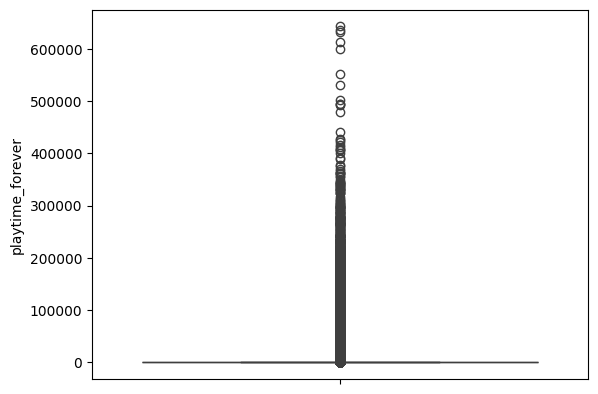

In [64]:
# Hago un diagrama de caja para ver outliers.
# Tiene muchos outliers. Si se consideran minutos, no tienen que ser necesariamente errores
sns.boxplot(data=user_items,y='playtime_forever') 

In [65]:
user_items.to_csv('../datasets/user_items_comp_csv.gz', compression='gzip', index=False)